In [1]:
%load_ext autoreload
%autoreload 2

from generative import dataset, utils, models
import jax
import jax.numpy as jnp
import optax
import orbax.checkpoint
from flax.training import orbax_utils
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct 

from tqdm import tqdm

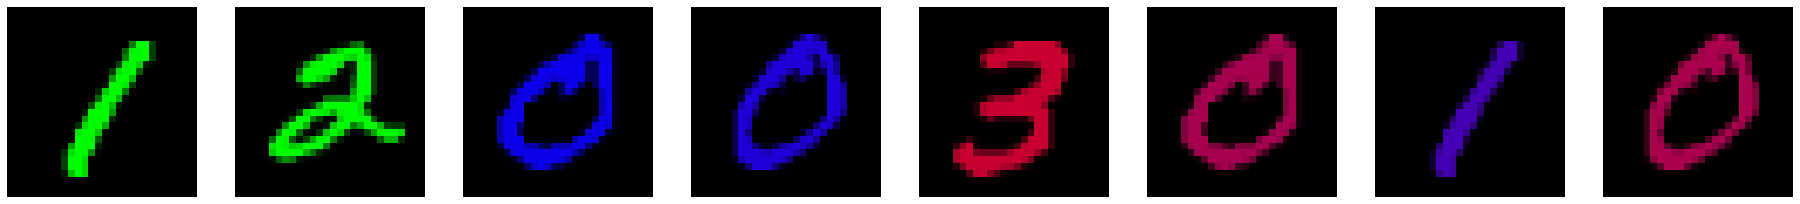

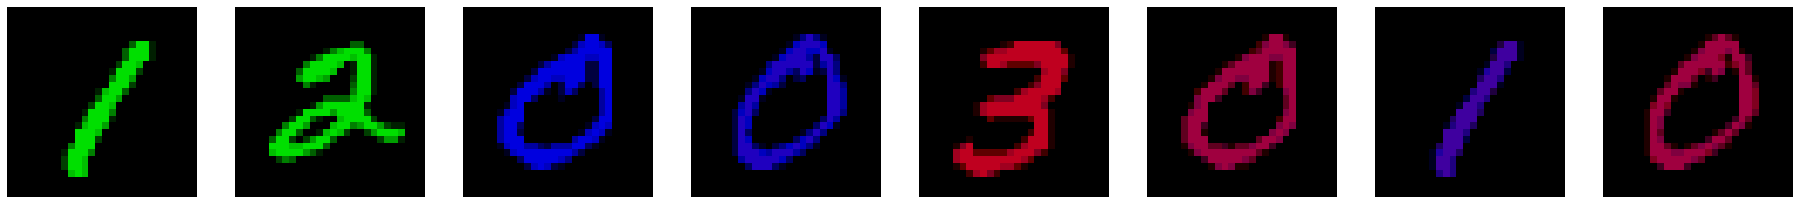

In [2]:
char_set = dataset.mnist_char_set()
rng = jax.random.PRNGKey(0)

# Ground Truth Images.
images, labels = dataset.mnist_colored(char_set, rng, batch_size=8)
utils.plot_image_row(images)

bins, flattened = dataset.process_data_bins(images)
bins_id = jnp.argmax(bins, axis=-1)

# Images created from bins.
image_reconstructed = flattened[:,:,:3].reshape((8, 28, 28, 3))
utils.plot_image_row(image_reconstructed)


In [3]:
TIME_HORIZON = 64
model = models.GeneratorRNNFlat()
dummy_input = jnp.zeros((1, 64*8))

@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
  metrics: Metrics

# Initialize the parameters, optimizer, etc.
def create_train_state(module, rng, learning_rate, dummy_input):
  params = module.init(rng, dummy_input)['params'] # initialize parameters by passing a template image
  tx = optax.adam(learning_rate)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

# One step of training.
@jax.jit
def train_step(state, inputs, bins, rng):

    # Run the model forward one step. Using params.
    def loss_fn(params):
        model_output = state.apply_fn({'params': params}, inputs)
        loss = optax.sigmoid_binary_cross_entropy(model_output, bins).mean()
        return loss
    # Compute gradient and apply an optimization step.
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    # Log metrics.
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

# Evaluation.

# Recreates USING TEACHER FORCING. 
def pred_step(state, rng):
  images, labels = dataset.mnist_colored(char_set, sub_rng, batch_size=1)
  bins, inputs = dataset.process_data_bins(images) # [batch, time, features.]
  # Inputs is [1, 784, 8].
  # Instead, it should become a [784-64, 64, 8] array. The time dimension = the 64 pixels that come before in time.
  inputs_new = jnp.zeros((28*28, TIME_HORIZON, 8))
  for i in range(TIME_HORIZON, 28*28-1):
      inputs_new = inputs_new.at[i-1].set(inputs[0, i-TIME_HORIZON:i])
  inputs_flat = inputs_new.reshape((-1, TIME_HORIZON*8))

  inputs_flat = inputs_flat[TIME_HORIZON:-1] # The first TIME_HORIZON bins are not used.
  bin_slice = bins[0, TIME_HORIZON+1:] # The correct bins are the bins that come after the time horizon.
  print(inputs_new.shape, bin_slice.shape, inputs_flat.shape)

  model_output = state.apply_fn({'params': state.params}, inputs_flat)

  truth = jnp.argmax(bin_slice, axis=-1)
  pred = jnp.argmax(model_output, axis=-1)
  print(truth.shape, pred.shape)

  print("Correct in Example:", jnp.sum(truth == pred) / truth.shape[0])

  truth = jnp.concatenate([jnp.ones((TIME_HORIZON+1,)), truth], axis=0)
  truth = truth.at[:TIME_HORIZON+1].set(120)
  pred = jnp.concatenate([jnp.ones((TIME_HORIZON+1,)), pred], axis=0)
  pred = pred.at[:TIME_HORIZON+1].set(120)

  colors = dataset.batch_bins_to_colors(truth)
  image_reconstructed = colors.reshape((1, 28, 28, 3))

  colors2 = dataset.batch_bins_to_colors(pred)
  image_reconstructed2 = colors2.reshape((1, 28, 28, 3))
  utils.plot_image_row(jnp.concatenate([images, image_reconstructed, image_reconstructed2], axis=0))


In [4]:
# TRAINING LOOP

# global_rng = jax.random.PRNGKey(0)
# sub_rng, global_rng = jax.random.split(global_rng)
# state = create_train_state(model, sub_rng, 3e-4, dummy_input=dummy_input)

# char_set = dataset.mnist_char_set()

# # Given inputs of size [batch, 28*28, features.]
# # Extracts a random time slice of size [batch, time, features.]
# def stagger_time(inputs, bins, indicies, time_length):
#     input_slice = jax.lax.dynamic_slice_in_dim(start_index=indicies, slice_size=time_length, axis=0, operand=inputs)
#     bin_slice = jax.lax.dynamic_slice_in_dim(start_index=indicies+1, slice_size=time_length, axis=0, operand=bins)
#     return input_slice, bin_slice
# batch_stagger_time = jax.jit(jax.vmap(stagger_time, in_axes=(0,0,0,None)), static_argnums=(3,))


# for step in tqdm(range(100*1000)):
#     batch_size = 64
#     sub_rng, global_rng = jax.random.split(global_rng)
#     images, labels = dataset.mnist_colored(char_set, sub_rng, batch_size=batch_size)

#     # Process the data.
#     sub_rng, global_rng = jax.random.split(global_rng)
#     bins, inputs = dataset.process_data_bins(images) # [batch, time, features.]
#     indicies = jax.random.randint(sub_rng, (batch_size,), minval=0, maxval=inputs.shape[1]-TIME_HORIZON-1)
#     input_slice, bin_slice = batch_stagger_time(inputs, bins, indicies, TIME_HORIZON)
#     # Input slice is [batch, time_horizon, features.]
#     # Bin slice is [batch, time_horizon, 512]
#     input_flat = input_slice.reshape((batch_size, TIME_HORIZON*8))
#     bin_flat = bin_slice[:, -1, :] # We only care about the last bin.

#     # Run a training step.
#     state = train_step(state, input_flat, bin_flat, sub_rng)

#     if step % 250 == 0:
#         for metric, value in state.metrics.compute().items(): # compute metrics
#             tqdm.write(f'[{step//50}] {metric}: {value:.4f}')
#         state = state.replace(metrics=state.metrics.empty())

#     if step % 500 == 0:
#         sub_rng, global_rng = jax.random.split(global_rng)
#         model_output = pred_step(state, sub_rng)
#         # utils.plot_image_row(model_output[:8])

# ckpt = {'model': state}
# orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# save_args = orbax_utils.save_args_from_target(ckpt)
# orbax_checkpointer.save('saves/rnn/', ckpt, save_args=save_args)

In [5]:
# ckpt = {'model': state}
# orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# save_args = orbax_utils.save_args_from_target(ckpt)
# orbax_checkpointer.save('saves/rnn_flat64_mnist/', ckpt, save_args=save_args)

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
global_rng = jax.random.PRNGKey(0)
sub_rng, global_rng = jax.random.split(global_rng)
state_template = create_train_state(model, sub_rng, 3e-4, dummy_input=dummy_input)
ckpt_template = {'model': state_template}
ckpt = orbax_checkpointer.restore('saves/rnn_flat64_mnist/', item=ckpt_template)
state = ckpt['model']

(784, 64, 8) (719, 512) (719, 512)
(719,) (719,)
Correct in Example: 0.9652295


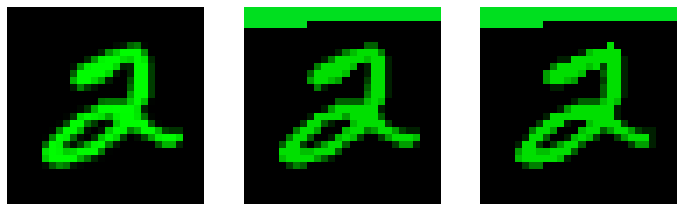

In [11]:
# Check teacher forcing.
pred_step(state, sub_rng)

100%|██████████| 528/528 [00:06<00:00, 76.32it/s]


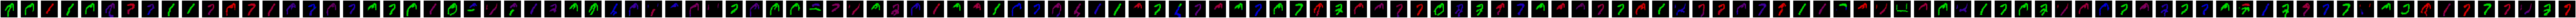

In [32]:
def gen_image(rng):

    batch_size = 128
    # Make the shared coordinate grid.
    x = jnp.linspace(0, 1, 28)
    y = jnp.linspace(0, 1, 28)
    xv, yv = jnp.meshgrid(x, y, indexing='ij')
    xv = xv.reshape((1, 28, 28, 1)).repeat(1, axis=0)
    yv = yv.reshape((1, 28, 28, 1)).repeat(1, axis=0)
    coordinates = jnp.concatenate([xv, yv], axis=-1).reshape((1, 28*28, 2))
    is_edge = (yv == 1).reshape(-1, 1)

    HINT_SIZE = 64

    images, _ = dataset.mnist_colored(char_set, rng, batch_size=batch_size)
    bins, inputs = dataset.process_data_bins(images) # [batch, time, features.]
    current_generated = inputs[:, :HINT_SIZE] # [Batch, Time_Horizon, Features.]
    truth_bin = jnp.argmax(bins, axis=2) # These are the true bins that should be predicted. Ignore the first TIME_HORIZON.

    # @jax.jit
    def gen_helper(current_slice, truth_bin, rng):
        current_slice_flat = current_slice.reshape((batch_size, TIME_HORIZON*8))
        model_output = state.apply_fn({'params': state.params}, current_slice_flat)
        # pred_bin = jnp.argmax(model_output, axis=-1)
        pred_bin = jax.random.categorical(rng, model_output, axis=-1)

        colors = dataset.batch_bins_to_colors(pred_bin)
        xy = coordinates[:, t].repeat(batch_size, axis=0)
        edge = is_edge[t].reshape((1,1)).repeat(batch_size, axis=0)
        new_generated = jnp.concatenate([colors, xy, (1-xy), edge], axis=-1).reshape((batch_size, 1, 8))
        return new_generated

    for t in tqdm(range(HINT_SIZE, 28*(28))):
        sub_rng, rng = jax.random.split(rng)
        new_generated = gen_helper(current_generated[:,t-TIME_HORIZON:t], truth_bin[:, t], sub_rng)
        current_generated = jnp.concatenate([current_generated, new_generated], axis=1)

    # image_truth = images[:, :]
    image_reconstructed = current_generated[:,:,:3].reshape((batch_size, 28, 28, 3))
    return image_reconstructed

sub_rng, global_rng = jax.random.split(global_rng)
img = gen_image(sub_rng)
utils.plot_image_row(img)

In [ ]:
# def gen_step(state, rng, batch_size):
#     current_generated = jnp.zeros((batch_size, 1, 5))
#     for t in tqdm(range(28*14-1)):
#         model_output = state.apply_fn({'params': state.params}, current_generated[:,-64:])
#         choices = jax.random.categorical(rng, model_output, axis=-1)[:,-1:]
#         x = t % 28
#         y = t // 28
#         colors = dataset.batch_bins_to_colors(choices)
#         xy = jnp.array([x, y]).reshape((1, 1, 2)).repeat(batch_size, axis=0) / 28
#         new_generated = jnp.concatenate([colors, xy], axis=-1).reshape((batch_size, 1, 5))
#         current_generated = jnp.concatenate([current_generated, new_generated], axis=1)
#     return current_generated
# flattened = gen_step(state, rng, 4)
# image_reconstructed = flattened[:,:,:3].reshape((4, 28, 14, 3))
# utils.plot_image_row(image_reconstructed)


In [ ]:
# # Restore model into 'state'
# orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# global_rng = jax.random.PRNGKey(0)
# sub_rng, global_rng = jax.random.split(global_rng)
# state_template = create_train_state(model, sub_rng, 3e-4, dummy_input=dummy_input)
# ckpt_template = {'model': state_template}
# ckpt = orbax_checkpointer.restore('saves/vae/', item=ckpt_template)
# state = ckpt['model']

100%|██████████| 100/100 [00:06<00:00, 15.80it/s]


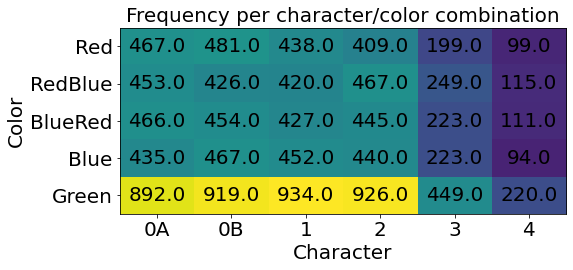

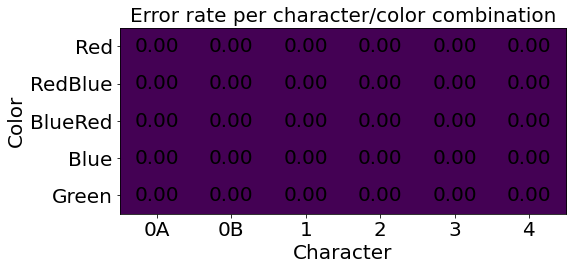

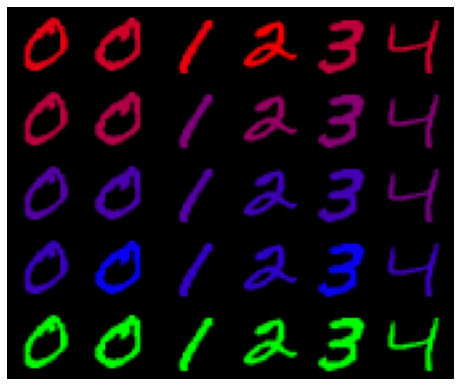

In [27]:
# Charts for Ground Truth Data

char_set = dataset.mnist_char_set()
frequency_table = jnp.zeros((5,6))
error_table = jnp.zeros((5,6))
examples_table = jnp.zeros((5,6,28,28,3))
for i in tqdm(range(100)):
    # make batch of 128 images. then categorize them. put the counts into frequency.
    sub_rng, global_rng = jax.random.split(global_rng)
    images = dataset.mnist_colored(char_set, sub_rng, batch_size=128)[0]
    chars, colors, error = dataset.categorize(char_set, images)
    frequency_table = frequency_table.at[colors, chars].add(1)
    error_table = error_table.at[colors, chars].add(error)
    examples_table = examples_table.at[colors, chars].set(images)
utils.plot_frequency_table(frequency_table)
utils.plot_error_table(error_table, frequency_table)
utils.plot_examples_table(examples_table)

100%|██████████| 100/100 [11:56<00:00,  7.17s/it]


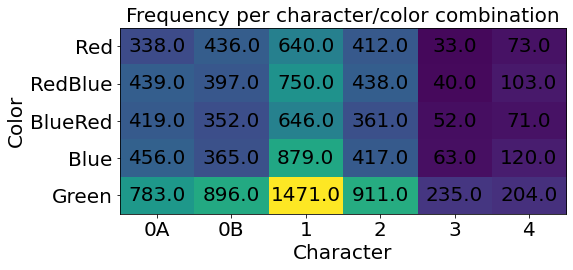

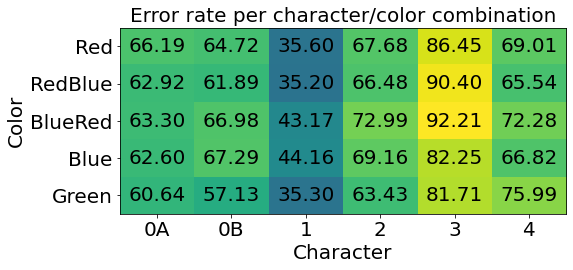

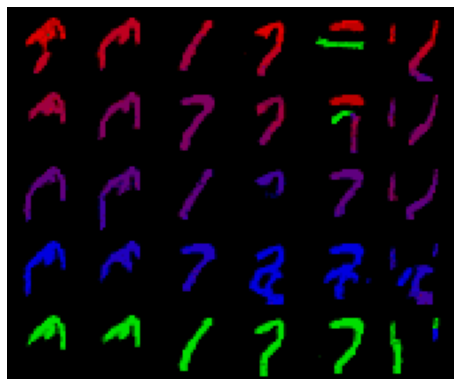

In [33]:
# Charts for Generated Data

char_set = dataset.mnist_char_set()
frequency_table = jnp.zeros((5,6))
error_table = jnp.zeros((5,6))
examples_table = jnp.zeros((5,6,28,28,3))
for i in tqdm(range(100)):
    # make batch of 128 images. then categorize them. put the counts into frequency.
    sub_rng, global_rng = jax.random.split(global_rng)
    images = gen_image(sub_rng)
    chars, colors, error = dataset.categorize(char_set, images)
    frequency_table = frequency_table.at[colors, chars].add(1)
    error_table = error_table.at[colors, chars].add(error)
    examples_table = examples_table.at[colors, chars].set(images)
utils.plot_frequency_table(frequency_table)
utils.plot_error_table(error_table, frequency_table)
utils.plot_examples_table(examples_table)

In [ ]:
utils.plot_examples_table(examples_table)